In [11]:
import sys
sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")

import numpy as np
import astropy

from astropy.time import Time
from astroquery.jplhorizons import Horizons
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
import matplotlib.pyplot as plt
# Load standard kernels
spice.load_standard_kernels()


In [12]:

def create_ephemeris_dictionary_from_horizons_table(
        horizons_table ):

    """Creates a dictionary of times/states from a Horizons Table output (see https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html#astroquery.jplhorizons.HorizonsClass.vectors), to be used as input for tabulated ephemeris settings.

    Parameters
    ----------
    horizons_table : astropy.table.Table
        Table of states, as directly retried from JPL Horizons through astroquery (typically using the jpl_horizons_ephemeris_table function)

    Returns
    -------
    Dictionary (times as key; Cartesian states as value) storing a body state history, as retrieved from JPL Horizons

    """

    # Create dictionary, and iterate over horizons output table	
    ephemeris_table = dict( )
    for i in range(len(horizons_table)):

        # Conert time format to Tudat format
        current_time_jd_tdb = Time( horizons_table['datetime_jd'][ i ], format = 'jd', scale='utc')
        julian_days_since_j2000 = current_time_jd_tdb.jd1 - constants.JULIAN_DAY_ON_J2000
        current_time = ( julian_days_since_j2000 + current_time_jd_tdb.jd2 ) * constants.JULIAN_DAY
        
        # Convert state to SI units, and store in dictionary
        ephemeris_table[ current_time ] = np.array([
            horizons_table['x'][i] * constants.ASTRONOMICAL_UNIT,
            horizons_table['y'][ i ] * constants.ASTRONOMICAL_UNIT,
            horizons_table['z'][ i ] * constants.ASTRONOMICAL_UNIT,
            horizons_table['vx'][i] * constants.ASTRONOMICAL_UNIT / constants.JULIAN_DAY_ON_J2000,
            horizons_table['vy'][ i ] * constants.ASTRONOMICAL_UNIT / constants.JULIAN_DAY_ON_J2000,
            horizons_table['vz'][ i ] * constants.ASTRONOMICAL_UNIT / constants.JULIAN_DAY_ON_J2000
        ])

    return ephemeris_table


def jpl_horizons_ephemeris_table(
        body_identifier,
        central_body_identifier,
        epochs ):

    """Creates a Horizons Table (see https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html), and converts it to a dictionary of times/states, to be used as input for tabulated ephemeris settings.

    Parameters
    ----------
    body_identifier : str
        Horizons-compatible string identfying the body for which stats are to be generated
    central_body_identifier : str
	Horizons-compatible string identfying the central body (observer) w.r.t. which stats are to be generated
    epochs: list[float]
        List of seconds since J2000 (TDB) at which Horizons is to be queried. Note that the conversion to julian (as needed by Horizons) is done inside this funcion

    Returns
    -------
    Dictionary (times as key; Cartesian states as value) storing a body state history, as retrieved from JPL Horizons

    """

    # Convert time from seconds since J2000 to julian days
    epochs_julian_days = [ epoch / constants.JULIAN_DAY + constants.JULIAN_DAY_ON_J2000 for epoch in epochs]

    # Query Horizons for the required body and time interval
    obj = Horizons(id=body_identifier, location=central_body_identifier,epochs=epochs_julian_days)

    # Extract the table of Cartesian states
    return create_ephemeris_dictionary_from_horizons_table(obj.vectors())



def jpl_horizons_tabulated_ephemeris_settings(
        body_identifier,
        central_body_identifier,
        epochs ):

    """Uses JPL Horizons (see https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html), to create tabulated ephemeris settings.

    Parameters
    ----------
    body_identifier : str
        Horizons-compatible string identfying the body for which stats are to be generated
    central_body_identifier : str
	Horizons-compatible string identfying the central body (observer) w.r.t. which stats are to be generated
    epochs: list[float]
        List of seconds since J2000 (TDB) at which Horizons is to be queried. Note that the conversion to julian (as needed by Horizons) is done inside this funcion


    Returns
    -------
    ``TabulatedEphemerisSettings`` containing data retrieved from JPL horizons, for the given bodies and times, for the creation of a tabulated ephemeris

    """
    # Create ephemeris settings from table
    ephemeris_settings = environment_setup.ephemeris.tabulated(
        jpl_horizons_ephemeris_table( body_identifier, central_body_identifier, epochs ),
        central_body_identifier )
    return ephemeris_settings


In [13]:

# Define test epochs
# epochs = [0.0, constants.JULIAN_DAY, constants.JULIAN_YEAR]

start = 20 * 365 * 86400
end = 23 * 365 * 86400

npoints = 50
times = np.linspace(start, end, npoints)
times_plot = times / (86400*365.25) + 2000

# Get table of states from Horizons
ephemeris_table = jpl_horizons_ephemeris_table('299', '399', times )
# ephemeris_table = jpl_horizons_ephemeris_table('299', 'Earth', epochs )

# Iterate over states from Horizons, and extract state from Spic
error = []
for key in ephemeris_table:
    spice_state = spice.get_body_cartesian_state_at_epoch( 'Venus', 'Earth', 'ECLIPJ2000', 'None', key )
    # print(spice_state)
    # print(ephemeris_table[key])
    error.append((spice_state-ephemeris_table[key])[0:3])
    # print(spice_state - ephemeris_table[key])
    # print('\n')

error = np.array(error)/1000

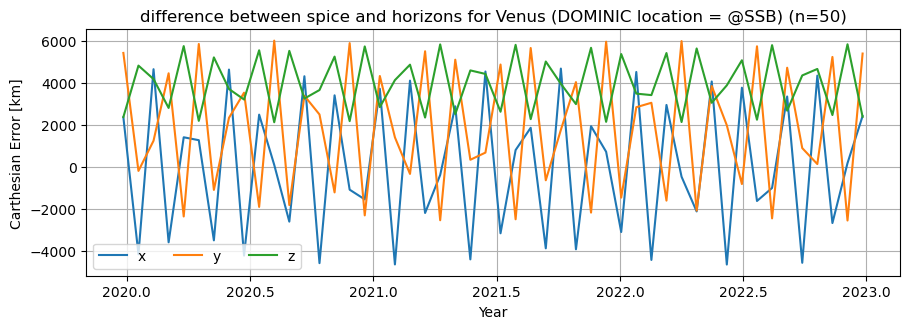

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(times_plot, error[:, 0], label="x")
ax.plot(times_plot, error[:, 1], label="y")
ax.plot(times_plot, error[:, 2], label="z")

ax.grid()
ax.legend(ncol=3)

plt.tight_layout()
ax.set_title(f"difference between spice and horizons for Venus (DOMINIC location = @SSB) (n={npoints})")
ax.set_ylabel("Carthesian Error [km]")
ax.set_xlabel("Year")

plt.show()

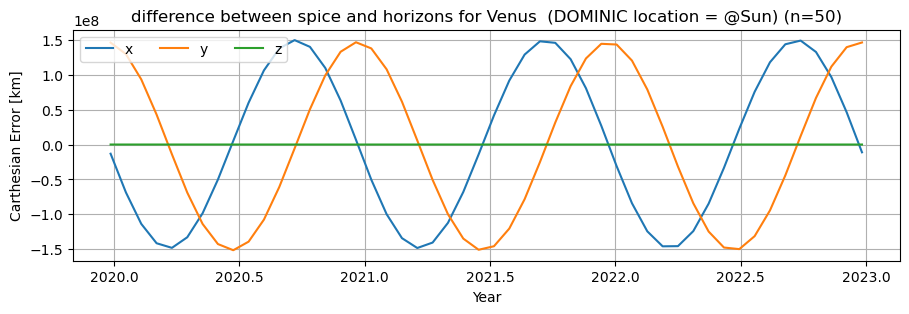

In [17]:

# Define test epochs
# epochs = [0.0, constants.JULIAN_DAY, constants.JULIAN_YEAR]

start = 20 * 365 * 86400
end = 23 * 365 * 86400

npoints = 50
times = np.linspace(start, end, npoints)
times_plot = times / (86400*365.25) + 2000

# Get table of states from Horizons
ephemeris_table = jpl_horizons_ephemeris_table('299', '0', times )
# ephemeris_table = jpl_horizons_ephemeris_table('299', '@Sun', epochs )

# Iterate over states from Horizons, and extract state from Spic
error = []
for key in ephemeris_table:
    spice_state = spice.get_body_cartesian_state_at_epoch( 'Venus', 'Sun', 'ECLIPJ2000', 'None', key )
    # print(spice_state)
    # print(ephemeris_table[key])
    error.append((spice_state-ephemeris_table[key])[0:3])
    # print(spice_state - ephemeris_table[key])
    # print('\n')

error = np.array(error)/1000


fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(times_plot, error[:, 0], label="x")
ax.plot(times_plot, error[:, 1], label="y")
ax.plot(times_plot, error[:, 2], label="z")

ax.grid()
ax.legend(ncol=3)

plt.tight_layout()
ax.set_title(f"difference between spice and horizons for Venus  (DOMINIC location = @Sun) (n={npoints})")
ax.set_ylabel("Carthesian Error [km]")
ax.set_xlabel("Year")

plt.show()